In [ ]:
import pandas as pd
import osmnx as ox

# Load the nodes files
complete_nodes = pd.read_csv("nodes_complete.csv", sep=";")
incomplete_nodes = pd.read_csv("bologna_nodes_p.csv", sep=";")




# Load the edges files
complete_edges = pd.read_csv("edges_complete.csv", sep=";")
incomplete_edges = pd.read_csv("bologna_edges_p.csv", sep=";")


# Check if there are edges without nodes

# assert set(incomplete_edges["u_original"]).issubset(set(incomplete_nodes["osmid_original"]))
# assert set(incomplete_edges["v_original"]).issubset(set(incomplete_nodes["osmid_original"]))
# assert set(complete_edges["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(complete_edges["v_original"]).issubset(set(complete_nodes["osmid_original"]))

# #   ERRORE   

# assert set(incomplete_edges["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(incomplete_edges["v_original"]).issubset(set(complete_nodes["osmid_original"]))


# Define residential flags
FLAGS_RESIDENTIAL = [
    "residential",
    "living_street",
    "unclassified",
    "service",
    "pedestrian",
    "busway",
]

# Filter the complete edges for residential streets
residential_streets = complete_edges[complete_edges["highway"].isin(FLAGS_RESIDENTIAL)]

# Extract all nodes (u and v) from the incomplete graph
incomplete_nodes_set = set(incomplete_nodes["osmid_original"])
print(incomplete_nodes_set[0])

# Find residential streets adjacent to the incomplete graph
streets_to_add = []
for _, row in residential_streets.iterrows():
    u, v = row["u_original"], row["v_original"]
    
    if u in incomplete_nodes_set or v in incomplete_nodes_set:
        streets_to_add.append(row.to_dict())
        



#                                                  ---------------------------- E' QUI IL PROBLEMA --------------------------------


# Create a DataFrame for new edges and append it to the incomplete edges
new_streets = pd.DataFrame(streets_to_add)
print(new_streets.head())
#   OK    #

# assert set(new_streets["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(new_streets["v_original"]).issubset(set(complete_nodes["osmid_original"]))

updated_incomplete_edges = pd.concat([incomplete_edges, new_streets], ignore_index=True)

#    ERRORE    #

# assert set(updated_incomplete_edges["u_original"]).issubset(set(complete_nodes["osmid_original"]))
# assert set(updated_incomplete_edges["v_original"]).issubset(set(complete_nodes["osmid_original"]))

# Extract all unique nodes used in the updated edges
updated_nodes_set = set(updated_incomplete_edges["u_original"].astype(str)).union(set(updated_incomplete_edges["v_original"].astype(str)))

# Filter the complete nodes to include only those in the updated nodes set
updated_nodes = complete_nodes[complete_nodes["osmid_original"].astype(str).isin(updated_nodes_set)]

# Append any missing nodes from the incomplete nodes to ensure coverage
#additional_nodes = incomplete_nodes[~incomplete_nodes["osmid_original"].isin(updated_nodes["osmid_original"])]
#updated_nodes = pd.concat([updated_nodes, additional_nodes], ignore_index=True)


# print(set(updated_incomplete_edges["u_original"])-set(updated_nodes["osmid_original"]))
# assert set(updated_incomplete_edges["u_original"]).issubset(set(updated_nodes["osmid_original"]))
# assert set(updated_incomplete_edges["v_original"]).issubset(set(updated_nodes["osmid_original"]))





# Save the updated edges
updated_incomplete_edges = updated_incomplete_edges.drop_duplicates(subset=["u", "v"])
updated_incomplete_edges = updated_incomplete_edges.drop_duplicates(subset=["u", "v"])


updated_incomplete_edges = updated_incomplete_edges[
         ["u_original", "v_original", "length", "oneway", "lanes", "highway", "maxspeed", "name", "geometry"]
     ]
updated_incomplete_edges.to_csv("bologna_edges.csv", index=False, sep=";")

# Save the updated nodes file
updated_nodes = updated_nodes[["osmid_original", "x", "y", "highway", "geometry"]]
updated_nodes.to_csv("bologna_nodes.csv", index=False, sep=";")

print("Updated nodes and edges files have been created.")


TypeError: 'set' object is not subscriptable

In [210]:
from shapely import wkt
import geopandas as gpd

updated_nodes["geometry"] = updated_nodes["geometry"].apply(wkt.loads)
updated_incomplete_edges["geometry"] = updated_incomplete_edges["geometry"].apply(wkt.loads)

updated_nodes = gpd.GeoDataFrame(updated_nodes, geometry="geometry")
updated_incomplete_edges = gpd.GeoDataFrame(updated_incomplete_edges, geometry="geometry")
updated_nodes = updated_nodes.set_geometry("geometry")
updated_incomplete_edges = updated_incomplete_edges.set_geometry("geometry")


In [211]:
from shapely.geometry import Point

updated_nodes["geometry"] = updated_nodes.apply(lambda row: Point(row["x"], row["y"]), axis=1)
assert updated_nodes.crs == updated_incomplete_edges.crs, "CRS mismatch between nodes and edges"

if not isinstance(updated_incomplete_edges.index, pd.MultiIndex):
    updated_incomplete_edges.set_index(["u_original", "v_original", "lanes"], inplace=True)



In [212]:
if updated_nodes.crs is None:
    updated_nodes = updated_nodes.set_crs("EPSG:4326")

if updated_incomplete_edges.crs is None:
    updated_incomplete_edges = updated_incomplete_edges.set_crs("EPSG:4326")

graph2 = ox.graph_from_gdfs(updated_nodes, updated_incomplete_edges)


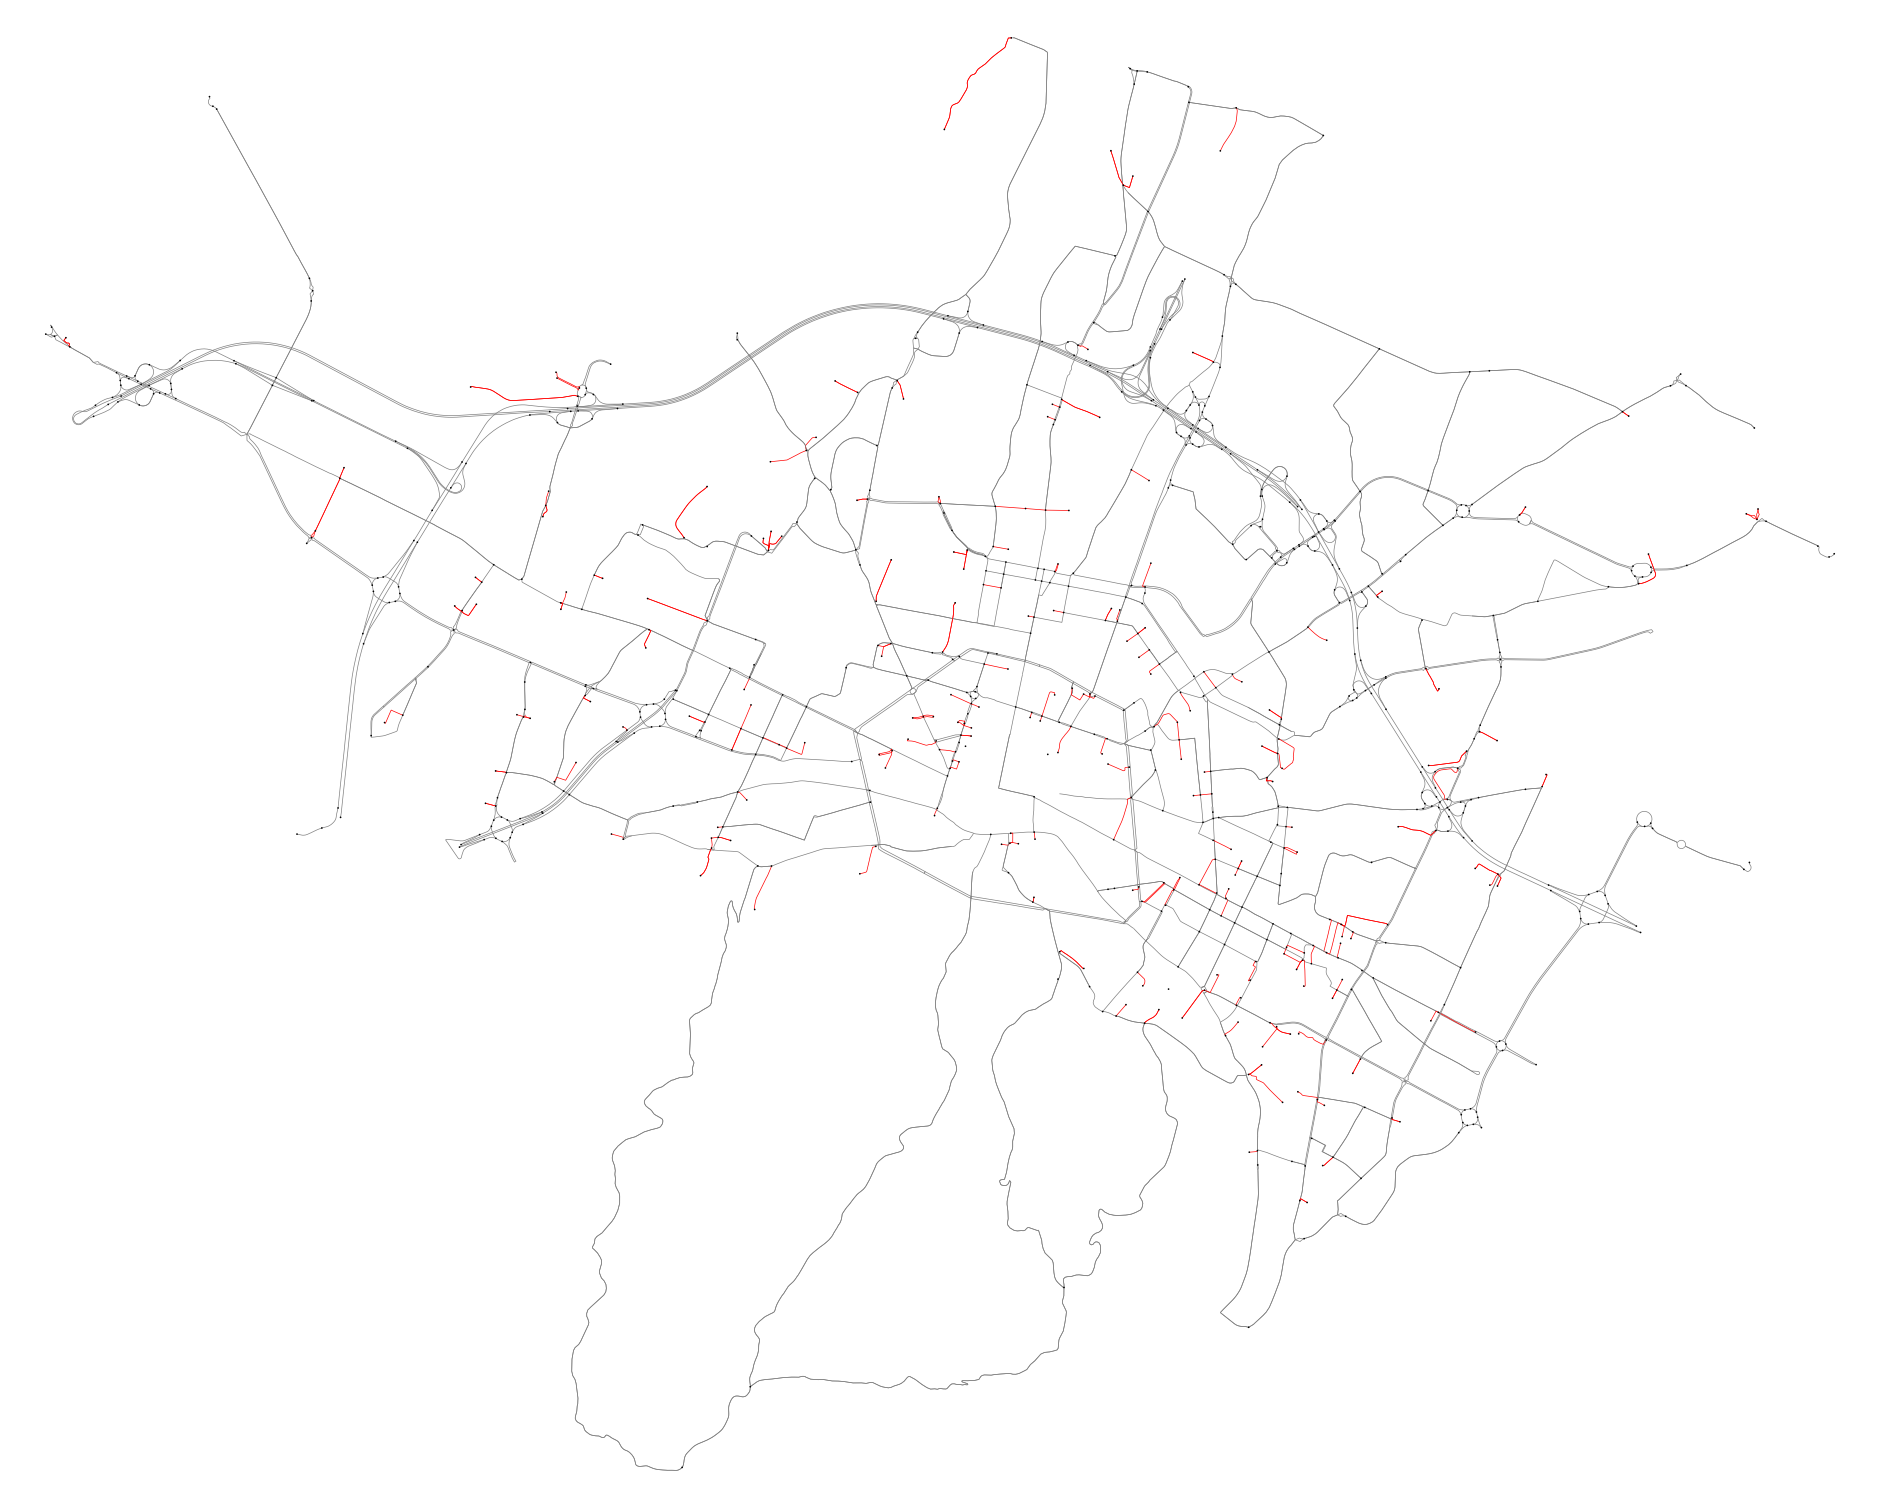

In [213]:
import matplotlib.pyplot as plt


# Extract edge data and color based on the "highway" attribute
edge_colors = []
for u, v, data in graph2.edges(data=True):
    if data.get("highway") in ['residential', 'living_street', 'unclassified', 'service', 'pedestrian', 'busway']:
        edge_colors.append("red")
    else:
        edge_colors.append("gray")

# Plot the graph with custom edge colors
fig, ax = ox.plot_graph(
    graph2,
    edge_color=edge_colors,
    node_size=1.5,  # Adjust node size as needed
    node_color="black",
    bgcolor="white",  # Background color
    edge_linewidth=0.5,  # Edge line width
    figsize=(24, 24),
    show=True,
    save=True  # Set to True if you want to save the plot
)
